Next we will import all the required libraries. As we are making a CNN model we will import all the required layers, activations, optimizers, etc.  

In [1]:

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.image import imread
import cv2
import random
import os
from os import listdir
from PIL import Image
from sklearn.preprocessing import label_binarize,  LabelBinarizer
from keras.preprocessing import image
from keras.preprocessing.image import img_to_array, array_to_img
from tensorflow.keras.optimizers import Adam
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D
from keras.layers import Activation, Flatten, Dropout, Dense
from sklearn.model_selection import train_test_split
from keras.models import model_from_json
from tensorflow.keras.utils import to_categorical 
from keras import callbacks
import sklearn.metrics as metrics

Now we will observe some of the iamges that are their in our dataset. We will plot 12 images here using the matplotlib library.

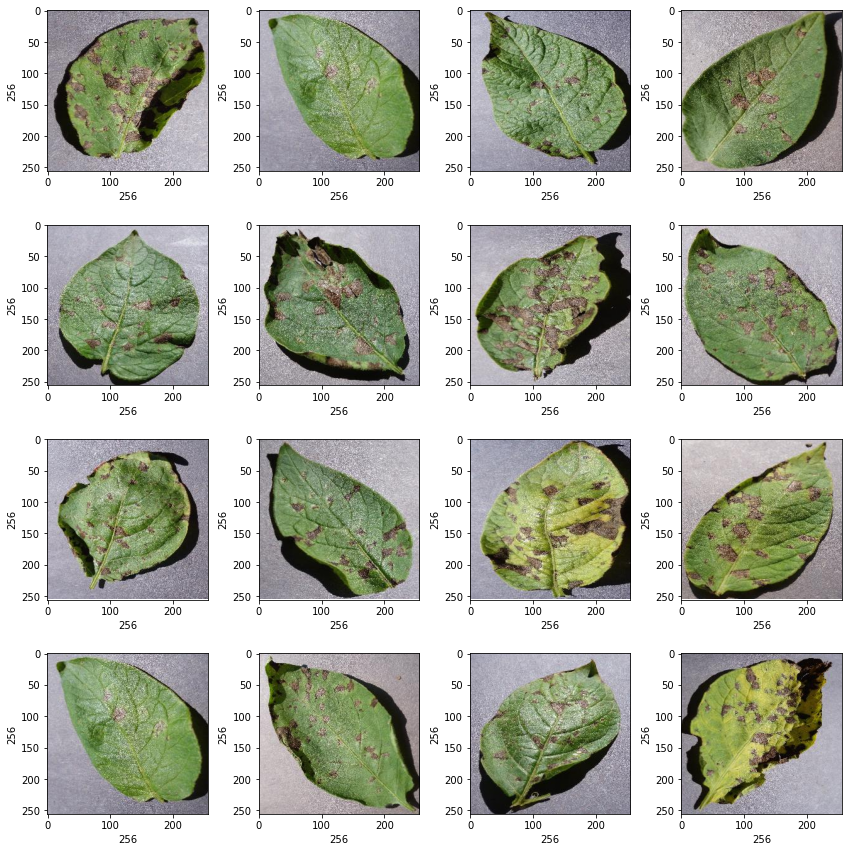

In [2]:
# Plotting 12 images to check dataset
plt.figure(figsize=(12,12))

path = "/Users/md/Downloads/Plant Disease Flask App/Data/Plant_images_pianalytix/Potato___Early_blight"
for i in range(1,17):
    plt.subplot(4,4,i)
    plt.tight_layout()
    rand_img = imread(path +'/'+ random.choice(sorted(os.listdir(path))))
    plt.imshow(rand_img)
    plt.xlabel(rand_img.shape[1], fontsize = 10)#width of image
    plt.ylabel(rand_img.shape[0], fontsize = 10)#height of image

After visualizing the images let us move forward and create a function which will convert the images into a numpy array. It is required because we will normalize our dataset after this.

In [3]:
#Converting Images to array 
def convert_image_to_array(image_dir):
    try:
        image = cv2.imread(image_dir)
        if image is not None :
            image = cv2.resize(image, (256,256))  
            #image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY) 
            return img_to_array(image)
        else :
            return np.array([])
    except Exception as e:
        print(f"Error : {e}")
        return None

Now we will convert all the images into numpy array.

In [5]:
dir = "/Users/md/Downloads/Plant Disease Flask App/Data"
root_dir = listdir(dir)
image_list, label_list = [], []
all_labels = ['Corn-Common_rust', 'Potato-Early_blight', 'Tomato-Bacterial_spot']
binary_labels = [0,1,2]
temp = -1

# Reading and converting image to numpy array
for directory in root_dir:
  plant_image_list = listdir(f"{dir}/{directory}")
  temp += 1
  for files in plant_image_list:
    image_path = f"{dir}/{directory}/{files}"
    image_list.append(convert_image_to_array(image_path))
    label_list.append(binary_labels[temp])

We will also observe the number of images under different classes to see if the dataset is balanced or not

In [6]:
# Visualize the number of classes count
label_counts = pd.DataFrame(label_list).value_counts()
label_counts.head()

0    300
2    300
1      1
dtype: int64

Next we will observe the shape of the image.

In [7]:
image_list[0].shape

(256, 256, 3)

Checking the total number of the images which is the length of the labels list.

In [6]:
label_list = np.array(label_list)
label_list.shape

(900,)

Next we will use sklearn train_test_split to split the dataset into testing and training data. Here I have taken test size as 0.2 so my data will be divided into 80% training and 20% testing data.

In [7]:
x_train, x_test, y_train, y_test = train_test_split(image_list, label_list, test_size=0.2, random_state = 10) 

Now we will normalize the dataset of our images. As pixel values ranges from 0 to 255 so we will divide each image pixel with 255 to normalize the dataset.

In [8]:
x_train = np.array(x_train, dtype=np.float16) / 225.0
x_test = np.array(x_test, dtype=np.float16) / 225.0
x_train = x_train.reshape( -1, 256,256,3)
x_test = x_test.reshape( -1, 256,256,3)

In [9]:
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)

Next we will create a network architecture for the model. We have used different types of layers according to their features namely Conv_2d (It is used to create a convolutional kernel that is convolved with the input layer to produce the output tensor), max_pooling2d (It is a downsampling technique which takes out the maximum value over the window defined by poolsize), flatten (It flattens the input and creates a 1D output), Dense (Dense layer produce the output as the dot product of input and kernel).


In [10]:
model = Sequential()
model.add(Conv2D(64, (3, 3), padding="same",input_shape=(256,256,3), activation="relu"))
model.add(MaxPooling2D(pool_size=(3, 3)))
model.add(Conv2D(32, (3, 3), padding="same",input_shape=(256,256,3), activation="relu"))
model.add(MaxPooling2D(pool_size=(3, 3)))
model.add(Conv2D(16, (3, 3), padding="same", activation="relu"))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Flatten())
model.add(Dense(8, activation="relu"))
model.add(Dense(3, activation="softmax"))
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 256, 256, 64)      1792      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 85, 85, 64)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 85, 85, 32)        18464     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 28, 28, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 28, 28, 16)        4624      
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 14, 14, 16)       0

While compiling the model we need to set the type of loss which will be Binary Crossentropy for our model alongwith this we also need to set the optimizer and the metrics respectively.

In [11]:
model.compile(loss = 'categorical_crossentropy', optimizer = Adam(0.0001),metrics=['accuracy'])

Next we will split the dataset into validation and training data.

In [12]:
# Splitting the training data set into training and validation data sets
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size = 0.2)

Fitting the model with the data and finding out the accuracy at each epoch to see how our model is learning. Now we will train our model on 10 epochs and a batch size of 128. You can try using more number of epochs to increase accuracy but here we can see that the model has already raeched a very high accuracy so we don't need to run it for more. During each epochs we can see how the model is performing by viewing the training and validation accuracy.

In [17]:
# Training the model
import datetime
import tensorflow as tf
earlystopping= callbacks.EarlyStopping(monitor='val_loss', mode='min',patience=5, restore_best_weights= True)

epochs = 100
batch_size = 128
log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)
history = model.fit(x_train, y_train, batch_size = batch_size, epochs = epochs, 
                    validation_data = (x_val, y_val), callbacks=[tensorboard_callback])

Epoch 1/100
5/5 [==============================] - 21s 4s/step - loss: 0.5024 - accuracy: 0.6858 - val_loss: 0.6017 - val_accuracy: 0.5764
Epoch 2/100
5/5 [==============================] - 19s 4s/step - loss: 0.4910 - accuracy: 0.6858 - val_loss: 0.6014 - val_accuracy: 0.5764
Epoch 3/100
5/5 [==============================] - 19s 4s/step - loss: 0.4800 - accuracy: 0.6858 - val_loss: 0.5805 - val_accuracy: 0.5764
Epoch 4/100
5/5 [==============================] - 20s 4s/step - loss: 0.4665 - accuracy: 0.6858 - val_loss: 0.5836 - val_accuracy: 0.5764
Epoch 5/100
5/5 [==============================] - 19s 4s/step - loss: 0.4608 - accuracy: 0.6858 - val_loss: 0.5627 - val_accuracy: 0.5764
Epoch 6/100
5/5 [==============================] - 17s 3s/step - loss: 0.4515 - accuracy: 0.6858 - val_loss: 0.5596 - val_accuracy: 0.5764
Epoch 7/100
5/5 [==============================] - 17s 3s/step - loss: 0.4447 - accuracy: 0.6858 - val_loss: 0.5496 - val_accuracy: 0.5764
Epoch 8/100
5/5 [==========

In [18]:
%tensorboard --logdir logs/fit

UsageError: Line magic function `%tensorboard` not found.


Next we will plot the accuracy of the model for the trainig history.

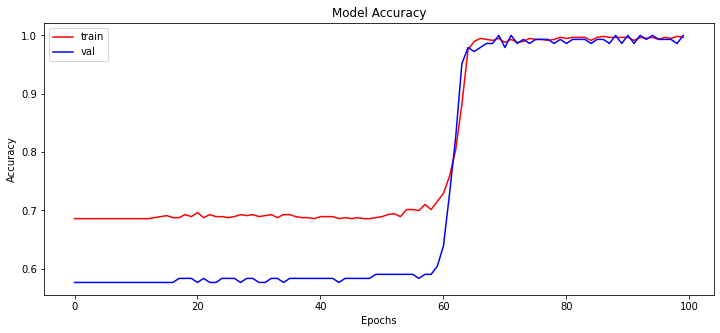

In [19]:
#Plot the training history
plt.figure(figsize=(12, 5))
plt.plot(history.history['accuracy'], color='r')
plt.plot(history.history['val_accuracy'], color='b')
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(['train', 'val'])
plt.show()

Evaluating the model to know the accuracy of the model.


In [20]:
print("[INFO] Calculating model accuracy")
scores = model.evaluate(x_test, y_test)
print(f"Test Accuracy: {scores[1]*100}")

[INFO] Calculating model accuracy
6/6 [==============================] - 1s 173ms/step - loss: 0.0183 - accuracy: 0.9944
Test Accuracy: 99.44444298744202


In [62]:
model.save('Plant Disease Flask App/Plant_Disease/plant_disease.h5')

Next we will use our model to predict predicting the testing dataset label.

In [21]:
y_pred = model.predict(x_test)

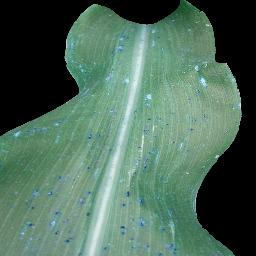

In [22]:
# Plotting image to compare
img = array_to_img(x_test[14])
img

Printing out the original and the predicted label.

In [23]:
# Finding max value from predition list and comaparing original value vs predicted
print("Originally : ",all_labels[np.argmax(y_test[12])])
print("Predicted : ",all_labels[np.argmax(y_pred[12])])


Originally :  Tomato-Bacterial_spot
Predicted :  Tomato-Bacterial_spot
